In [2]:
%matplotlib inline
%load_ext rpy2.ipython
repo = 'https://raw.githubusercontent.com/guester/Charleston-Data-Analytics-Cancer-Genomics-Data-Challenge/master/'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import os
import pickle
def fetch(url):
    fpath = '/tmp/genomics_analytics_'+url.split('/')[-1]+'.pkl'
    if os.path.exists(fpath):
        return pd.read_pickle(fpath)
    else:
        d = pd.read_csv(url)
        d.to_pickle(fpath)
        return d

In [4]:
d_cn_r = fetch(repo + 'copy_number.csv')

In [5]:
d_ge_r = fetch(repo + 'gene_expression.csv')

In [6]:
d_mu_r = fetch(repo + 'mutations.csv')

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

non_features = ['Response', 'Cell_Line']
response = 'Response'

scaler = StandardScaler()
res_enc = LabelEncoder()
res_enc.fit(['resistant', 'sensitive'])
res_enc.classes_

array(['resistant', 'sensitive'], 
      dtype='<U9')

In [8]:
def prep_generic(d, non_features, prefix):
    d = d[d['Response'] != 'hidden'].copy()
    d['Response'] = res_enc.transform(d['Response'])
    d = d.rename(columns=lambda x: prefix + x if x not in non_features else x)
    return d

def prep_numeric(d, non_features):
    # Drop columns with ALL NAs
    ncol = d.shape[1]
    d = d.dropna(axis=1, how='all')
    
    # Drop rows with fewer than 10 non-NA values
    nrow = d.shape[0]
    d = d.dropna(axis=0, how='all', thresh=10)
    
    # Standardize numeric values
    features = [c for c in d if not c in non_features]
    d[features] = d[features].apply(lambda x: scaler.fit_transform(x)).copy()
    
    print('Ncol before = {}, Ncol after = {}, Nrow before = {}, Nrow after = {}'\
        .format(ncol, d.shape[1], nrow, d.shape[0]))
    return d

def prep_character(d, non_features):
    # Drop columns with ALL NAs
    ncol = d.shape[1]
    d = d.dropna(axis=1, how='all')
    
    # Label encode remaining columns
    features = [c for c in d if not c in non_features]
    d[features] = d[features].apply(lambda x: LabelEncoder().fit_transform(x.fillna('NA'))).copy()
    
    print('Ncol before = {}, Ncol after = {}'\
        .format(ncol, d.shape[1]))
    return d

In [9]:
d_cn = prep_generic(d_cn_r, non_features, 'cn:')
d_ge = prep_generic(d_ge_r, non_features, 'ge:')
d_mu = prep_generic(d_mu_r, non_features, 'mu:')

In [10]:
print('Copy Number:')
d_cn = prep_numeric(d_cn, non_features)

print('Gene Expression:')
d_ge = prep_numeric(d_ge, non_features)

print('Mutations:')
d_mu = prep_character(d_mu, non_features)

Copy Number:
Ncol before = 39410, Ncol after = 21522, Nrow before = 81, Nrow after = 79
Gene Expression:
Ncol before = 39410, Ncol after = 16061, Nrow before = 81, Nrow after = 79
Mutations:
Ncol before = 39410, Ncol after = 1556


/Users/eczech/anaconda/envs/research3.3/lib/python3.3/site-packages/pandas/core/frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
list(map(len, [d_cn, d_mu, d_ge]))

[79, 81, 79]

In [12]:
data = pd.concat([d.set_index(non_features) for d in [d_cn, d_ge, d_mu]], axis=1, join='inner')
data = data.reset_index().set_index('Cell_Line')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, A375 to WSUDLCL2
Columns: 39134 entries, Response to mu:ZNF841
dtypes: float64(37579), int64(1555)
memory usage: 23.6+ MB


# Modeling

In [128]:
from ml import models, datasets
import imp
imp.reload(models)
imp.reload(datasets)

<module 'ml.datasets' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/datasets.py'>

In [14]:
data.head()

,Response,cn:A1BG,cn:A1BG.AS1,cn:A1CF,cn:A2M,cn:A2M.AS1,cn:A2ML1,cn:A2MP1,cn:A4GALT,cn:A4GNT,...,mu:ZNF470,mu:ZNF497,mu:ZNF521,mu:ZNF546,mu:ZNF573,mu:ZNF594,mu:ZNF608,mu:ZNF668,mu:ZNF717,mu:ZNF841
Cell_Line,,,,,,,,,,,,,,,,,,,,,
A375,0,-0.168216,-0.168216,-1.092218,0.000000,0.000000,-0.015456,0.000000,-0.906389,-0.376322,...,0,0,6,0,1,1,6,0,1,0
AMO1,0,1.160689,1.160689,-1.092218,1.187735,1.187735,1.205577,1.187735,-0.906389,-0.376322,...,1,0,6,0,1,1,6,0,1,0
CAL12T,0,-1.497120,-1.497120,1.832705,0.000000,0.000000,-0.015456,0.000000,-0.906389,1.039366,...,1,0,6,0,1,1,1,0,1,0
CFPAC1,0,-1.497120,-1.497120,1.832705,-1.187735,-1.187735,-1.236489,-1.187735,-0.906389,1.039366,...,1,0,6,0,1,1,6,0,1,0
COV318,0,1.160689,1.160689,-1.092218,0.000000,0.000000,-0.015456,0.000000,-0.906389,1.039366,...,1,0,6,0,1,1,0,0,1,0


In [98]:
features = [c for c in data if not c in non_features]
X, y = data[features], data[response]

In [99]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

GradientBoostingClassifier()
RandomForestClassifier()
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [102]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

# gbr_grid = {
#     'n_estimators': [100, 500],
#     'learning_rate': [.1, .01, .001],
#     'max_features': [1, .3, .1],
#     'min_samples_leaf': [3],
#     'max_depth': [2]
# }
# gbr_grid = {
#     'n_estimators': [1, 10, 100],
#     'learning_rate': [.1, .5, .01],
#     'max_features': [.1, .01],
#     'min_samples_leaf': [1],
#     'max_depth': [3, 5]
# }
logreg_grid = {
    'penalty': ['l1'],
    'C': np.logspace(-3, 3, 10)
}
clfs = {
    'gbr': GradientBoostingClassifier(loss='exponential', n_estimators=25),
    'ext': ExtraTreesClassifier(n_estimators=100),
    'rf': GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 150]}),
    'logreg': LogisticRegression(penalty='l1')
}

res = models.run_classifiers(X, y, clfs, StratifiedKFold(y, 5), 
                             keep_X=False, predict_proba=True, par_n_jobs=6)

[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-105] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-105] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-105] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-105] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/PoolWorker-103] child process calling self.run()
[INFO/PoolWorker-105] child process calling self.run()
[INFO/PoolWorker-104] child process calling self.run()
[INFO/Pool

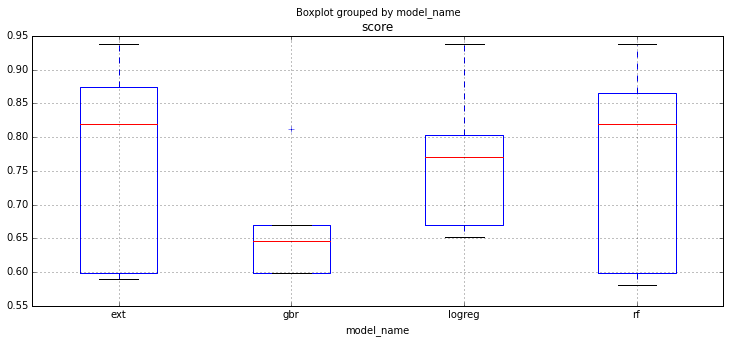

In [108]:
from sklearn.metrics import precision_score, roc_auc_score

#score_func = lambda clf, y_true, y_pred: precision_score(y_true, y_pred)
score_func = lambda clf, y_true, y_pred: roc_auc_score(y_true, y_pred)

roc_scores = models.summarize_scores(res, score_func, use_proba=False)
roc_scores.boxplot('score', 'model_name', figsize=(12,5))

In [104]:
imp.reload(models)
imp.reload(datasets)
x = models.summarize_curve(res)
x.head()

,model_name,fold_id,fpr,tpr
0,ext,1,0,0.250
1,ext,1,0,0.375
2,ext,1,0,0.500
3,ext,1,0,0.625
4,ext,1,0,0.750


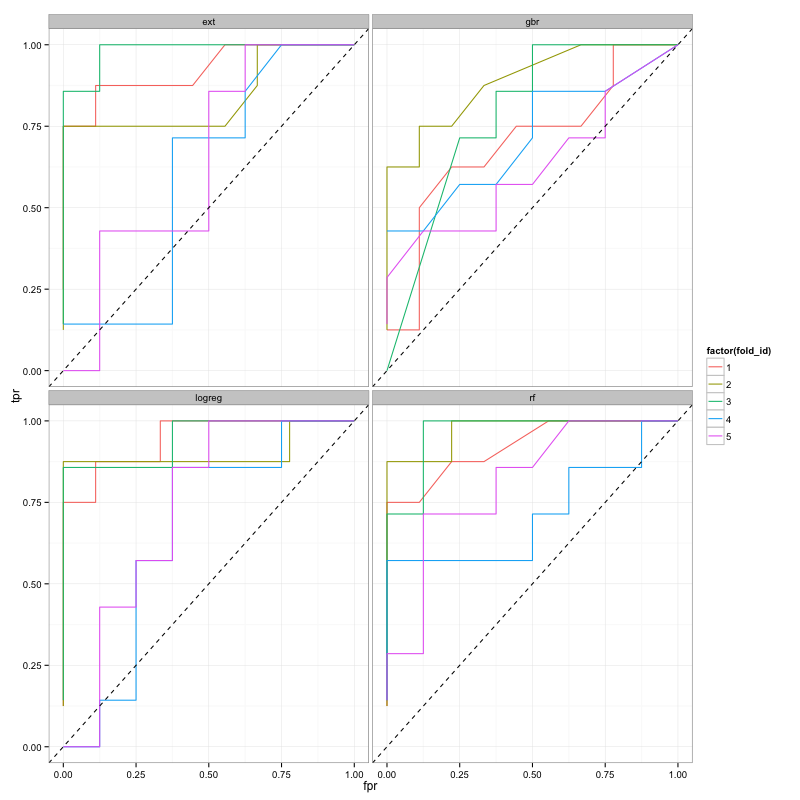

In [105]:
%%R -i x -w 800 -h 800 -u px

library(dplyr)
library(ggplot2)

x %>% mutate(fpr=as.numeric(fpr), tpr=as.numeric(tpr), fold_id=as.numeric(fold_id)) %>%
    ggplot(aes(x=fpr, y=tpr, color=factor(fold_id))) + geom_line() + facet_wrap(~model_name) + 
    theme_bw() + geom_abline(linetype='dashed')

In [138]:
feat_imp = models.summarize_importances(res)
x = feat_imp.drop('fold_id', axis=1)
x = x.groupby('model_name').aggregate(np.mean).T
x['logreg'] = np.abs(x['logreg'])
x.head()

model_name,ext,gbr,logreg,rf
cn:A1BG,0.000000,0,0,0.000000
cn:A1BG.AS1,0.000000,0,0,0.000000
cn:A1CF,0.000000,0,0,0.000059
cn:A2M,0.000000,0,0,0.000000
cn:A2M.AS1,0.000132,0,0,0.000000


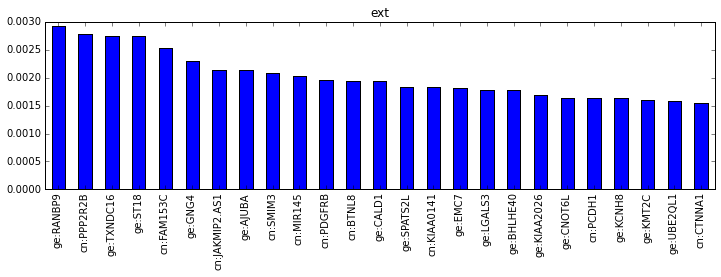

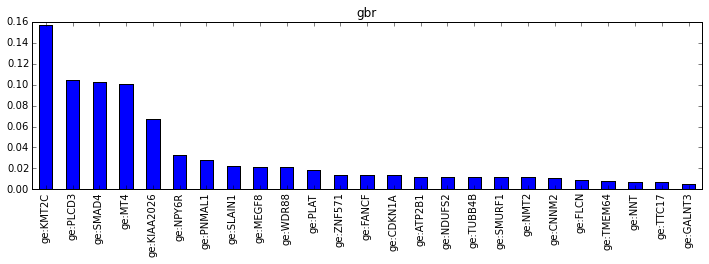

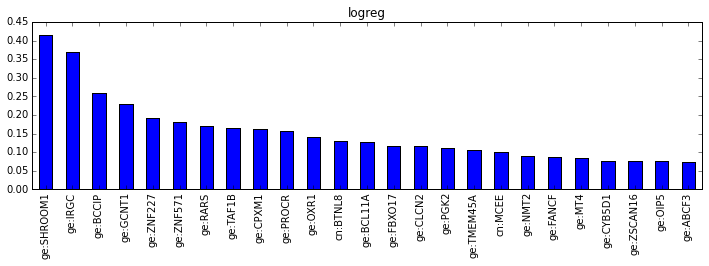

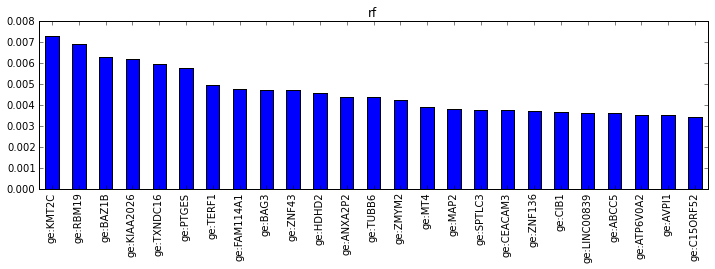

In [140]:
for model in x:
    plt.figure()
    ax = x[model].order(ascending=False).head(25).plot(kind='bar', figsize=(12,3))
    ax.set_title(model)

In [118]:
roc_scores.head()

,fold_id,model_name,score
0,1,rf,0.819444
1,1,ext,0.875000
2,1,gbr,0.645833
3,1,logreg,0.770833
4,2,rf,0.937500


In [156]:
x = pd.melt(feat_imp, id_vars=['model_name', 'fold_id'], var_name='feature', value_name='value')
x = x.groupby(['model_name', 'feature'])['value'].median().reset_index(name='value')
x.head()
y = roc_scores.groupby('model_name')['score'].median().reset_index(name='score')
pd.merge(x, y).head()

,model_name,feature,value,score
0,ext,cn:A1BG,0,0.819444
1,ext,cn:A1BG.AS1,0,0.819444
2,ext,cn:A1CF,0,0.819444
3,ext,cn:A2M,0,0.819444
4,ext,cn:A2M.AS1,0,0.819444


In [88]:
preds = models.summarize_predictions(res)
preds.head()

,y_pred,y_true,y_proba_0,y_proba_1,model_name,fold_id
0,0,0,0.82,0.18,rf,1
1,1,0,0.40,0.60,rf,1
2,0,0,0.68,0.32,rf,1
3,0,0,0.68,0.32,rf,1
4,0,0,0.70,0.30,rf,1
